# demo.ipynb

基于完整的历史数据，获得低比例饰品池的较优筛选规则

输入：饰品的 `steam_meta` 字段  
输出：是否将饰品加入池中 (True / False)

## 读取数据集

In [1]:
import os, json
from tqdm import tqdm
import pandas as pd
import numpy as np

In [2]:
dataset = []

for index in tqdm(range(20)):
    with open('data_{}.json'.format(index), 'r', encoding='utf-8') as f:
        dataset.extend(json.load(f))
print("Size of dataset:", len(dataset))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]

Size of dataset: 38075


## 预处理数据集

`overall_profit` 字段为该饰品在 buff 与 Steam Market 的 24 小时挂刀总利润（估计值，仅定性使用）

In [3]:
def compile_item(item):
    info = dict()
#     info['appid'] = item['buff_meta']['appid']
#     info['game'] = item['buff_meta']['game']
#     info['market_hash_name'] = item['buff_meta']['market_hash_name']
#     info['name'] = item['buff_meta']['name']
#     info['buff_id'] = item['buff_meta']['id']
    info['market_id'] = item['buff_meta']['market_id']

    info['sell_bum'] = item['buff_meta']['sell_num']
    info['buy_num'] = item['buff_meta']['buy_num']
    
    info['sell_min_price'] = eval(item['buff_meta']['sell_min_price'])
    info['buy_max_price'] = eval(item['buff_meta']['buy_max_price'])
    info['quick_price'] = eval(item['buff_meta']['quick_price'])
    
    if info['buy_max_price']:
        info['buff_ratio'] = info['sell_min_price'] / info['buy_max_price']
    else:
        info['buff_ratio'] = 999
    
    info['volume'] = eval(item['steam_overview'].get('volume', '0').replace(',',''))
    info['lowest_price'] = eval(item['steam_overview'].get('lowest_price', '￥ 0').replace(',', '')[2:])
    info['median_price'] = eval(item['steam_overview'].get('median_price', '￥ 0').replace(',', '')[2:])
    
    if info['lowest_price']:
        info['steam_ratio'] = info['quick_price'] / (info['lowest_price'] * 0.85)
        info['profit'] = (info['lowest_price'] * 0.85) - info['quick_price']
    else:
        info['steam_ratio'] = 99999
        info['profit'] = 0
    
    info['overall_profit'] = info['profit'] * info['volume']
    
    return info

In [4]:
full_list = [] # 仅通过 buff_meta 进行过滤，满足题目限制要求
filtered_list = [] # 通过 buff_meta, steam_volume 等进行过滤，不满足限制要求
positive_set = set() # 目标饰品（正例）的 id 集合

for item in tqdm(dataset):        
    i = compile_item(item)
    if i['quick_price'] < 1: continue # 去除价格过低的饰品

    full_list.append(i)
    
    if i['volume'] < 2: continue # 去除交易量过低的饰品
    if i['median_price'] * 2 < i['lowest_price']: continue # 去除价格过于不稳定的饰品
        
    filtered_list.append(i)
print("Size of full list:", len(full_list))
print("Size of filtered list:", len(filtered_list))

100%|█████████████████████████████████████████████████████████████████████████| 38075/38075 [00:01<00:00, 37133.81it/s]

Size of full list: 24590
Size of filtered list: 10623


正例条件一：总利润位于前 4000 位，筛选后挂刀比例位于前 2000 位

In [5]:
df = pd.DataFrame(filtered_list)
df = df.sort_values('overall_profit', ascending=False)[:4000]
df = df.sort_values('steam_ratio', ascending=True)[:2000]
for index, row in df.iterrows():
    positive_set.add(row['market_id'])
print("Size of positive instances:", len(positive_set))

Size of positive instances: 2000


正例条件二：价格在 10~500 元区间内，筛选后总利润位于前 3000 位，筛选后比例位于前 2500 位

In [6]:
df = pd.DataFrame(filtered_list)
df = df[df['quick_price'] > 10]
df = df[df['quick_price'] < 500]
print("Size of items with prices in (10, 500):", len(df))
df = df.sort_values('overall_profit', ascending=False)[:3000]
df = df.sort_values('steam_ratio', ascending=True)[:2500]
for index, row in df.iterrows():
    positive_set.add(row['market_id'])
print("Size of positive instances:", len(positive_set))

Size of items with prices in (10, 500): 4152
Size of positive instances: 3475


## 构造 feature 与 label

In [7]:
X = []
Y = []

for item in full_list:
    id_ = item['market_id']
    x = list(item.values())[1:7]
    
    X.append(x)
    if id_ in positive_set:
        Y.append(1)
    else:
        Y.append(0)

X = np.array(X)
Y = np.array(Y)
        
print("Shape of X", X.shape)
print("Shape of Y", Y.shape)
print("# positive instances: ", sum(Y))

Shape of X (24590, 6)
Shape of Y (24590,)
# positive instances:  3475


## 用 descision stump 做分类

recall 重要性大于 precision  
暂不划分 train/test, 直接考虑训练集上的metrics

In [8]:
from sklearn.tree import export_text, DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
import matplotlib.pyplot as plt

In [9]:
clf = DecisionTreeClassifier(max_depth=1, class_weight={0:1, 1:30})
clf = clf.fit(X, Y)
print("# predicted positive instances:", sum(clf.predict(X)))
print('Precision', precision_score(Y, clf.predict(X)))
print('Recall', recall_score(Y, clf.predict(X)))

# predicted positive instances: 12669
Precision 0.26758228747336016
Recall 0.9755395683453237


## 可视化分类规则

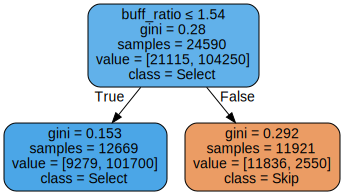

In [10]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None, 
                      feature_names=['sell_num', 'buy_num', 'sell_min_price', 'buy_max_price', 'quick_price', 'buff_ratio'],  
                      class_names=['Skip', 'Select'],
                      filled=True, rounded=True,  
                      special_characters=True)
graph = graphviz.Source(dot_data)
graph

In [11]:
r = export_text(clf, feature_names=['sell_num', 'buy_num', 'sell_min_price', 'buy_max_price', 'quick_price', 'buff_ratio'])
print(r)

|--- buff_ratio <= 1.54
|   |--- class: 1
|--- buff_ratio >  1.54
|   |--- class: 0



## 验证简单规则的分类效果

In [12]:
def simple_classifier(x):
    if x[5] < 1.54: return True
    return False
print("# predicted positive instances:", sum([simple_classifier(i) for i in X]))
print('Precision', precision_score(Y, [simple_classifier(i) for i in X]))
print('Recall', recall_score(Y, [simple_classifier(i) for i in X]))

# predicted positive instances: 12670
Precision 0.2675611681136543
Recall 0.9755395683453237
